출처: https://yamalab.tistory.com/118


#MNIST로 연습하는 비지도 학습

###1. K-means clustering
* data에 아무런 처리를 하지 않은 상태에서는 그다지 좋은 성능을 낼 수 없음
* 784차원으로 Euclidean distance 기반의 K-means clustering을 한 결과
* 0 이나 6같은 숫자는 비교적 잘 구분하는 반면, 나머지 숫자들은 군집이 덜 형성된듯함

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import ZeroPadding2D,Convolution2D,MaxPooling2D
from tensorflow.keras.layers import Dense,Dropout,Softmax,Flatten,Activation,BatchNormalization
from tensorflow.keras.preprocessing.image import load_img,img_to_array
from tensorflow.keras.applications.imagenet_utils import preprocess_input
import tensorflow.keras.backend as K

In [2]:
from keras.datasets import mnist

In [3]:
# Data 준비
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32')/255
x_test = x_test.astype('float32')/255
x_train = x_train.reshape((len(x_train), np.prod(x_test.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print (x_train.shape)
print (x_test.shape)

11493376/11490434 [==============================] - 0s 0us/step
(60000, 784)
(10000, 784)


In [4]:
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score

In [ ]:
model = KMeans(init="k-means++", n_clusters=10, random_state=0)
model.fit(x_train)
y_pred = model.labels_

def viz_img(y_pred):
    n=10
    fig = plt.figure(1)
    box_index = 1
    for cluster in range(10):
        result = np.where(y_pred == cluster)
        for i in np.random.choice(result[0].tolist(), n, replace=False):
            ax = fig.add_subplot(n, n, box_index)
            plt.imshow(x_train[i].reshape(28,28))
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            box_index += 1
    plt.show()


* 가로로 10개의 이미지가 하나의 군집을 나타냄

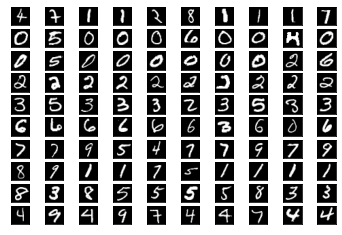

In [ ]:
viz_img(y_pred)

###2. Spherical Clustering
* 1번에서와 같은 Euclidean distance를 고차원 데이터에 적용하면 차원의 저주에 빠지므로 다른 거리를 계산하는 것이 좋음
* 일반적으로는 Cosine Distance나 Jaccard Index를 사용.. 하지만 이것도 고차원데이터에서는 그렇게까지 좋은 성능을 기대하기 어려움
* Hypersphere 기반의 K-means clustering을 적용한 코드: K-means clustering 보다 숫자를 깔끔하게 분리해냄 하지만 여전히 불분명한 군집을 outlier로 간주하여 구겨넣는 경향이 있음

* spherecluster 모듈 사용이 안되는듯. 에러 발생 일단 pass

* 참고 github: https://github.com/jasonlaska/spherecluster

In [ ]:
pip install spherecluster

     |████████████████████████████████| 163kB 10.1MB/s 


In [ ]:
from spherecluster import SphericalKMeans

ImportError: ignored

In [ ]:
skm = SphericalKMeans(n_clusters=10)
skm.fit(x_train)

viz_img(skm.labels_)

NameError: ignored

###3. PCA + K-means clustering
* PCA는 차원 축소의 성능이 그렇게까지 좋지는 못하다
* feature 단위의 일관된 규칙이 없는 고차원 data를 축소할 땐 더욱 그러함 (이런 경우 랜덤 샘플링을 한것이나 다름없는 군집 분류가 되기도 함)
* 잘 다듬어진 feature로 PCA를 수행한다면 data에 숨겨진 강력한 hidden feature 몇개를 잘 찾는 것 만으로도 K-means의 성능이 극적으로 향상됨
* 보수적인 군집 분석에서 가장 많이 사용하는 skill set이 PCA or SVD + K-means

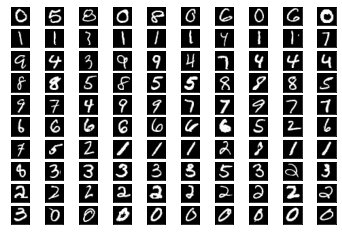

In [ ]:
from sklearn import decomposition

pca = decomposition.PCA(n_components=30).fit(x_train)
reduced_X = pca.transform(x_train)

from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score

model = KMeans(init="k-means++", n_clusters=10, random_state=0)
model.fit(reduced_X)
y_pred = model.labels_

viz_img(y_pred)

###4. t-SNE + DBSCAN
* t-SNE는 고차원 데이터를 축소하여 시각화 하는 용도로 주로 사용하는 알고리즘이다. 하지만 실행마다 그 결과가 조금씩 달라, 시각화 이외의 용도로 많이 쓰이지는 않는 것 같다. 
* 대안으로는 UMAP이 있음

* PCA와 다른 점은, 고차원의 피처가 가지고 있는 분포 기반의 hidden factor를 아주 잘 잡아내므로(그냥 뭐 성능차이.. 라고 할수도..) MNIST처럼 피처마다 상이한 분포를 가지고 있는 데이터에 적용해 볼 만 하다. 
* t-SNE으로 만들어낸 2차원 데이터를 클러스터링하기에 가장 적합한 알고리즘은 DBSCAN이다. (2차원으로 모든 포인트를 구겨넣으면서 생기는 고밀도의 군집을 잡아내기에 가장 좋기 때문)

* t-SNE 결과 2차원으로 축소된 데이터에 DBSCAN을 적용한 결과, 거의 지도학습 수준의 정확도를 보여준다. 
#####* 단점은 시간이 너무 오래 걸린다는 점. 또한 군집 밀도가 너무 높아지기 때문에, 큰 데이터에는 적용하기 힘들다는 것. 
#####* 장점은 성능 뿐 아니라, 시각화도 가능하다는 것.
    
* 시간 정말 오래 걸린다 model.fit 코드에서만 1시간 넘게 돌아가고 있음    


In [5]:
from sklearn.manifold import TSNE

model = TSNE(learning_rate=300)
transformed = model.fit_transform(x_train)

from sklearn.cluster import DBSCAN
model = DBSCAN(eps=2.4, min_samples=100)
predict = model.fit(transformed)
y_pred = predict.labels_

# Assign result to df
dataset = pd.DataFrame({'Column1':transformed[:,0],'Column2':transformed[:,1]})
dataset['cluster_num'] = pd.Series(predict.labels_)

viz_img(y_pred)

NameError: ignored

###5. Autoencoder

* AE를 비롯한 DL 계열의 차원 축소 방법이 현재 기준으로는 가장 성능이 좋은 방법이다. 
* 가장 큰 장점은 피처 엔지니어링을 자동으로 해준다는 것. (MNIST 예시에는 적용하지 않았지만, 1~4번 방법들은 모두 피처 엔지니어링을 잘 해야 한다는 전제가 필요하다. 그래서 반복적으로 클러스터를 돌려보고, 분석가의 주관으로 피처를 만지작 거려야 한다는 큰 걸림돌이 있다.)

* AE를 이용한 차원축소기법 참고 링크: https://yamalab.tistory.com/116

* 각설하고, 200차원으로 임베딩된 데이터로 군집을 나눠본 결과는 아래와 같다. t-SNE에 비해 정확도가 많이 떨어져 보이지만, 레이어를 추가하거나 하이퍼 파라미터를 잘 조절하면 t-SNE로 차원을 축소한 것과 비슷하거나 더 나은 성능을 보일 것 같다. 예시는 아직 cost 수렴 지점에 도달하지 않은 결과를 사용했기 때문

In [ ]:
from keras.layers import Input, Dense
from keras.models import Model
from keras import backend as K

# configure
encoding_dim = 200
input_img = Input(shape=(784,))


# layers
encoded = Dense(encoding_dim, activation='relu')(input_img)
decoded = Dense(784, activation='sigmoid')(encoded)


# Models
autoencoder = Model(input_img, decoded) # autoencoder

encoder = Model(input_img, encoded) # encoder

encoded_input = Input(shape=(encoding_dim,))
decoder_layer = autoencoder.layers[-1]
decoder = Model(encoded_input, decoder_layer(encoded_input)) # decoder

def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1))

def recall(y_true, y_pred):
    y_true_yn = K.round(K.clip(y_true, 0, 1))
    y_pred_yn = K.round(K.clip(y_pred, 0, 1))

    count_true_positive = K.sum(y_true_yn * y_pred_yn)
    count_true_positive_false_negative = K.sum(y_true_yn)
    recall = count_true_positive / (count_true_positive_false_negative + K.epsilon())
    return recall


# train autoencoder
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy', metrics=[rmse, recall])
autoencoder.fit(x_train, x_train,
                epochs=100,
                batch_size=512,
                shuffle=True,
                validation_data=(x_test, x_test))


# encoding result
encoded_imgs = encoder.predict(x_train)
decoded_imgs = decoder.predict(encoded_imgs)

from spherecluster import SphericalKMeans

skm = SphericalKMeans(n_clusters=10)
skm.fit(x_train)

viz_img(skm.labels_)

###6. UMAP
* 참고자료 출처: https://data-newbie.tistory.com/134 (코드)
* https://data-newbie.tistory.com/169 (기반 설명)


In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
X_train, X_test, y_train, y_test = train_test_split(
    embedding ,  labelcode , test_size=0.2, random_state=42)
svc = LinearSVC(dual=False, random_state=123)
params_grid = {"C": [10**k for k in range(-3, 4)]}
from sklearn.calibration import CalibratedClassifierCV
clf = GridSearchCV(svc, params_grid)
cclf = CalibratedClassifierCV(base_estimator=clf , cv=5)
cclf.fit(X_train, y_train)
prob = cclf.predict_proba(X_test)[:,1]
print("Accuracy on the test set with raw data: {:.3f}".format(
    cclf.score(X_test, y_test)))
    
    ## Accuracy on the test set with raw data: 0.919 !!!!!!!!!!!!!!!!!!!!

* Parameter 설정 가능

In [ ]:
umap = UMAP(random_state=456)
pipeline = Pipeline([("umap", umap),
                     ("svc", svc)])
params_grid_pipeline = {"umap__n_neighbors": [5, 20],
                        "umap__n_components": [15, 25, 50],
                        "svc__C": [10**k for k in range(-3, 4)]}

clf_pipeline = GridSearchCV(pipeline, params_grid_pipeline)
clf_pipeline.fit(X_train, y_train)
print("Accuracy on the test set with UMAP transformation: {:.3f}".format(
    clf_pipeline.score(X_test, y_test)))